In [610]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import lines
import matplotlib.collections as collections
import seaborn as sns

In [400]:
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error as mse
from scipy.stats import f
from scipy.signal import argrelmax

from stats import VIP

In [401]:
data = pd.read_csv("20201025_Dataset_plots_n216.csv")

In [406]:
# only using Flag leaf data
cleanData = data[(data['NotAnalizedFor'].isna()) & (data['LeafType'] == 'FlagLeaf')]
cleanData = cleanData.drop(columns=map(str, range(329, 400)))
calData = cleanData[cleanData['Cal_Val'] == 'Cal']
valData = cleanData[cleanData['Cal_Val'] == 'Val']

In [403]:
# Whole section based on T. Mehmood (2016) paper
# R impl: https://rdrr.io/github/khliland/plsVarSel/src/R/T2.R
def upperlimit(weights, alpha=0.0025):
    '''
    Calculate the upper Limit C(p, A*)F(A*, p-A*, alpha) based on Hotteling's-T2
    C(p, A*) = A*(p-1)/(p-A*)
    weights - matrix of loading weights with shape (p, A*)
    A* - number of components (cols)
    p - number of X variables (rows)
    '''
    p, A = weights.shape
    c = A*(p-1)/(p-A)
    F = f.ppf(1-alpha, A, p-A)
    return c*F

def T2(weights):
    '''
    based on: https://github.com/cran/MSQC/blob/master/R/mult.chart.R
    calculates the Hotteling's-T2 for Weights matrix
    weights - matrix of weights of dimensions p X A*
    A* is number of components
    
    returns a list containing the T2 for each X variable
    '''
    inv_cov = np.linalg.pinv(np.cov(weights, rowvar=False)) # meaning variables (components) are in columns
    Wmv = weights.mean(axis=0) # Weights' mean of variable. mean val of each component's weight
    Wdiff = weights-Wmv
    t2 = [V_diff.T @ inv_cov @ V_diff for V_diff in Wdiff]
    return t2

def selectVars(weights, Xvars, alpha=1e-3):
    '''
    using Hotteling's-T2 and loading weights of the PLS model choose the significant variables
    weights - loading weights of PLS model
    Xvars - vector of x variables names (wavelength numbers)
    returns: 
    selected variables names
    '''
    cutoff = upperlimit(weights, alpha)
    t2 = T2(weights)
    passedVars = t2 > cutoff
    return Xvars[passedVars]

In [509]:
def runModel(cal, val, predict, ps=None, maxLoadings=10, alpha=[0.2, 0.15, 0.1, 0.05, 0.01]):
    '''
    select the important variables for the model
    cal - calibration set
    val - validation set
    predit - column containing variable to predict
    ps - list containing X variables of model
    loadings - max ammount of loadings in the PLS model
    '''
    try: # is ps not None might fail cause it is a pandas
        if ps == None:
            # after column 11 the wavelength variables start
            ps = cal.columns[11:]
    except:
        pass
    # R2, RMSE, is validation, is selection
    dataStore = []
    Xcal = cal[ps]
    Xval = val[ps]
    ycal = cal[predict]
    yval = val[predict]
    loadings = findOptimalLoadings(Xcal, ycal, maxLoadings)
    pls = PLSRegression(n_components = loadings, scale=False)
    pls.fit(Xcal, ycal)
    oVIP = VIP(pls) # original model VIP
    calPredict = pls.predict(Xcal)
    valPredict = pls.predict(Xval)
    dataStore.append([predict, pls.score(Xcal, ycal), mse(ycal, calPredict, squared=False), ps, oVIP, len(ps), 0, 0, None])
    dataStore.append([predict, pls.score(Xval, yval), mse(yval, valPredict, squared=False), ps, oVIP, len(ps), 1, 0, None])

    weights = pls.x_weights_
    K = np.empty((len(alpha), 6))
    V = []
    VIPs = []
    predicts = []
    for i, a in enumerate(alpha):
        selected = selectVars(weights, ps, alpha=a) # TODO all variables pass the test - suspicious
        t2_Xcal = cal[selected]
        t2_Xval = val[selected]
        t2_loadings = findOptimalLoadings(t2_Xcal, ycal, np.min([maxLoadings, len(selected)-1]))
        t2_pls = PLSRegression(n_components = t2_loadings, scale=False)
        t2_pls.fit(t2_Xcal, ycal)
        score_cal = t2_pls.score(t2_Xcal, ycal)
        yhat_cal = t2_pls.predict(t2_Xcal)
        rmse_cal = mse(ycal, yhat_cal, squared=False)
        
        score = t2_pls.score(t2_Xval, yval)
        yhat = t2_pls.predict(t2_Xval)
        rmse = mse(yval, yhat, squared=False)
        K[i] = score_cal, rmse_cal, score, rmse, len(selected), a
        V.append(selected)
        VIPs.append(VIP(t2_pls))
        predicts.append(((ycal ,yhat_cal),(yval ,yhat)))
    
    # minimal RMSE
    p = np.where(K[:, 3] == np.min(K[:, 3]))[0]
    minData = K[p[0]]  
    minVars = V[p[0]]
    minVIP = VIPs[p[0]]
    t2predicts = predicts[p[0]]
    dataStore.append([predict, minData[0], minData[1], minVars, minVIP, len(minVars), 0, 1, minData[5]]) # cal-sel
    dataStore.append([predict, minData[2], minData[3], minVars, minVIP, len(minVars), 1, 1, minData[5]]) # val-sel
    collection = pd.DataFrame(data=dataStore, columns=['Type', 'R2', 'RMSE', 'vars', 'VIP', 'var_len', 'val',
                                                       'selection', 'alpha'])
    return collection, ((ycal, calPredict), (yval, valPredict)), t2predicts


In [623]:
def rescue_code(function):
    import inspect
    get_ipython().set_next_input("".join(inspect.getsourcelines(function)[0]))

rescue_code(findOptimalLoadings)

In [624]:
def findOptimalLoadings(X, y, maxLoadings):
    scores = np.zeros((maxLoadings, 2))
    for i in range(len(scores)):
        ncomp = i+1
        pls = PLSRegression(n_components=ncomp, scale=False) # range starts from 0
        cv=10
        # PRESS = SIGMA(MSEcv * k) when k is n of each cv
        scores[i] = ncomp, (cross_val_score(pls, X, y, cv=cv, scoring='neg_mean_squared_error').sum())*(len(y)/cv)
    # argrelmax instead of argelmin - looking for min PRESS but scoring returns -PRESS. So search for max -PRESS
    # argrelmax can return many minima. get the first local minima [0][0]
    try:
        min_ind = argrelmax(scores[:, 1])[0][0]
    except IndexError: # no max
        min_ind = 0
    return scores[min_ind, 0].astype(int)


In [510]:
#Ca, Cb, TChl
print("===Ca===")
CaData, CaPredict, CaT2Predict = runModel(calData, valData, 'Ca')
print("===Cb===")
CbData, CbPredict, CbT2Predict = runModel(calData, valData, 'Cb')
print("===TChl===")
TChlData, TChlPredict, TChlT2Predict = runModel(calData, valData, 'TChl')
allData = pd.concat([CaData, CbData, TChlData])

===Ca===


/home/uri/.local/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:353: UserWarning: X scores are null at iteration 8
  warnings.warn('X scores are null at iteration %s' % k)
/home/uri/.local/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:353: UserWarning: X scores are null at iteration 8
  warnings.warn('X scores are null at iteration %s' % k)
/home/uri/.local/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:353: UserWarning: X scores are null at iteration 8
  warnings.warn('X scores are null at iteration %s' % k)
/home/uri/.local/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:353: UserWarning: X scores are null at iteration 8
  warnings.warn('X scores are null at iteration %s' % k)
/home/uri/.local/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:353: UserWarning: X scores are null at iteration 8
  warnings.warn('X scores are null at iteration %s' % k)
/home/uri/.local/lib/python3.8/site-packages/sklearn/cr

===Cb===


/home/uri/.local/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:353: UserWarning: X scores are null at iteration 7
  warnings.warn('X scores are null at iteration %s' % k)
/home/uri/.local/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:353: UserWarning: X scores are null at iteration 7
  warnings.warn('X scores are null at iteration %s' % k)
/home/uri/.local/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:353: UserWarning: X scores are null at iteration 7
  warnings.warn('X scores are null at iteration %s' % k)
/home/uri/.local/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:353: UserWarning: X scores are null at iteration 7
  warnings.warn('X scores are null at iteration %s' % k)
/home/uri/.local/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:353: UserWarning: X scores are null at iteration 7
  warnings.warn('X scores are null at iteration %s' % k)
/home/uri/.local/lib/python3.8/site-packages/sklearn/cr

===TChl===


In [567]:
CaData.vars[0].astype(int).min()

400

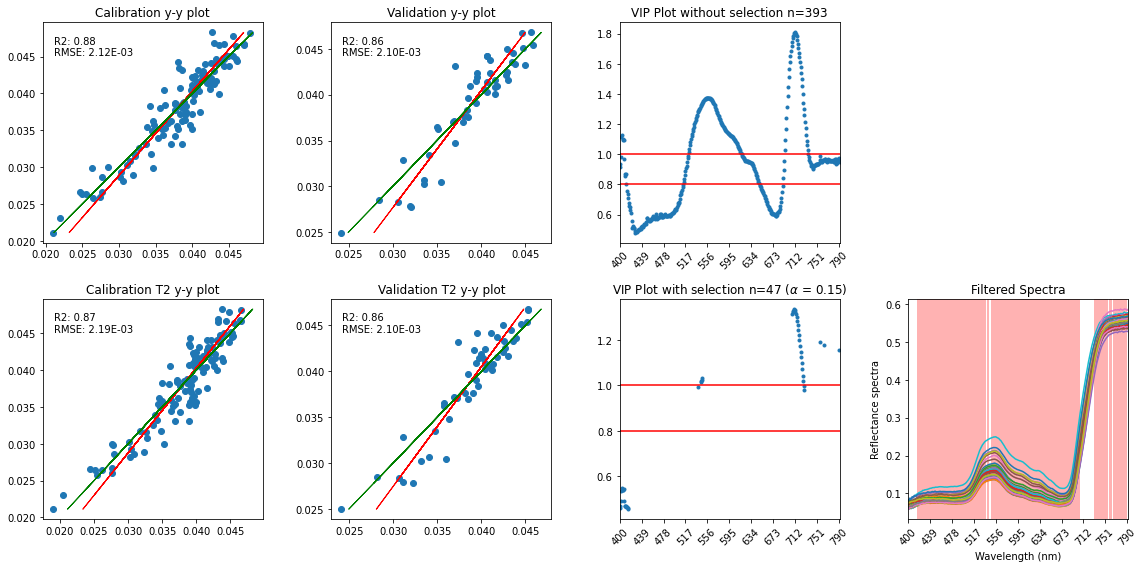

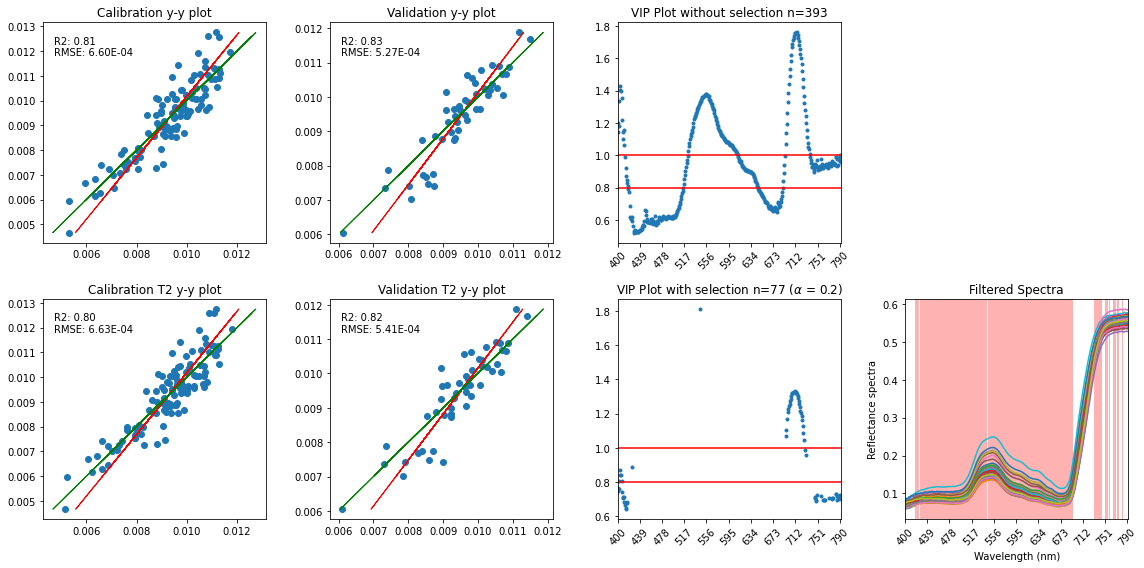

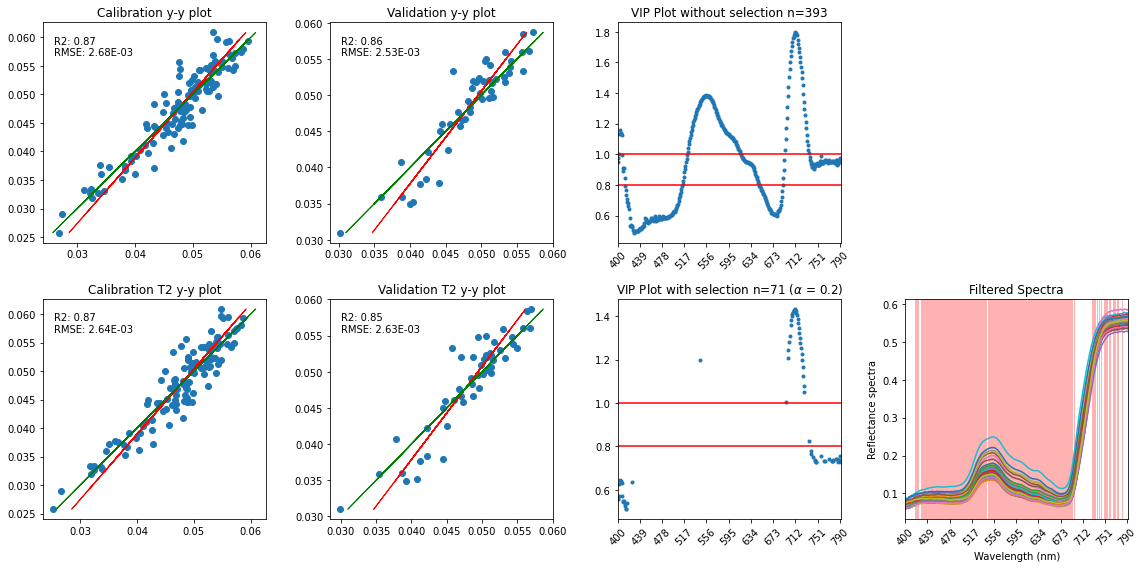

In [622]:
def drawGraph(ax, data, R2, RMSE):
    ax.scatter(x=data[1], y=data[0])
    z = np.polyfit(data[0], data[1], 1)
    ax.plot(np.polyval(z, data[0]), data[0], color='red', linewidth=1)
    ax.plot(data[0], data[0], linewidth=1, c='green')
    ax.text(0.05, 0.85, f"R2: {R2:.2f}\nRMSE: {RMSE:.2E}", transform=ax.transAxes)

def drawVIP(ax, wls, vips, lmin, lmax):
    ax.set_xlim(lmin, lmax)
    xticks = np.arange(lmin, lmax, math.floor((lmax-lmin)/10))
    ax.set_xticks(xticks)
    ax.tick_params(axis='x', labelrotation=45)
    ax.scatter(wls.astype(int), vips, marker='.')
    ax.plot([lmin, lmax], [1,1], color='red')
    ax.plot([lmin, lmax], [0.8, 0.8], color='red')

def drawFiltered(ax, data, selected, lmin, lmax):
    ax.set_xlim(lmin, lmax)
    xticks = np.arange(lmin, lmax, math.floor((lmax-lmin)/10))
    ax.set_xticks(xticks)
    ax.tick_params(axis='x', labelrotation=45)
    ax.set_ylabel('Reflectance spectra')
    ax.set_xlabel('Wavelength (nm)')
    
    ax.plot(data.columns.astype(int), data.T)
    wls = np.arange(wlmin, wlmax, 1)
    ix = np.in1d(wls, selected)
    collection = collections.BrokenBarHCollection.span_where(
    wls, ymin=0, ymax=1, where=ix == False, facecolor='red', alpha=0.3) # mark the non-selected
    ax.add_collection(collection)

def drawForValue(data, predict, t2predict, val_data, loc):
    wls = data.vars[0].astype(int)
    wlmin, wlmax = wls.min(), wls.max()

    fig, axes = plt.subplots(2, 4, figsize=((4*4, 4*2)))
    ax00 = axes[0][0]
    ax00.set_title("Calibration y-y plot")
    drawGraph(ax00, predict[0], data.R2[0],data.RMSE[0])

    ax01 = axes[0][1]
    ax01.set_title("Validation y-y plot")
    drawGraph(ax01, predict[1], data.R2[1], data.RMSE[1])

    ax02 = axes[0][2]
    ax02.set_title(f"VIP Plot without selection n={len(data.vars[0])}")
    drawVIP(ax02, data.vars[0], data.VIP[0], wlmin, wlmax)

    ax03 = axes[0][3]
    ax03.set_frame_on(False)
    ax03.set_axis_off()

    ax10 = axes[1][0]
    ax10.set_title("Calibration T2 y-y plot")
    drawGraph(ax10, t2predict[0], data.R2[2], data.RMSE[2])

    ax11 = axes[1][1]
    ax11.set_title("Validation T2 y-y plot")
    drawGraph(ax11, t2predict[1], data.R2[3], data.RMSE[3])

    ax12 = axes[1][2]
    alpha_symb = r'$\alpha$'
    ax12.set_title(f"VIP Plot with selection n={len(data.vars[2])} ({alpha_symb} = {data.alpha[2]})")
    drawVIP(ax12, data.vars[2] ,data.VIP[2], wlmin, wlmax)

    ax13 = axes[1][3]
    ax13.set_title("Filtered Spectra")
    drawFiltered(ax13, val_data[data.vars[0]], data.vars[2].astype(int), wlmin, wlmax)
    fig.tight_layout()
    fig.savefig(f'./{loc}')

drawForValue(CaData, CaPredict, CaT2Predict, valData, loc="CaAnaly.png")
drawForValue(CbData, CbPredict, CbT2Predict, valData, loc="CbAnaly.png")
drawForValue(TChlData, TChlPredict, TChlT2Predict, valData, loc="TChlAnaly.png")